# MIT 15.776: Hands-On Deep Learning
## Final Project: Disaster Tweets Analysis 

**Giuseppe Iannone, Luca Sfragara, Trisha Sutivong, Hanna Zhang**

This notebook contains our exploration of NLP models to classify tweets into real (1) and fake (0) announcements of disaster. TODO: talk more about the format of this notebook, what is the narrative?



In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras
import keras_tuner as kt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
keras.utils.set_random_seed(42) # setting seed 
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


### Step 0: Loading Data
The data set comprises of 7,613 labeled tweets for training and 3,263 unlabeled tweets for evaluation. Each instance contains: 
- Text: The tweet content (max 280 characters)
- Keyword: Optional disaster-related keyword (e.g., “wildfire”, “earthquake”)
- Location: Optional user-provided location information
- Target: Binary label (1 = real disaster, 0 = not a disaster)

Because the test set given by competition is unlabeled, we will separate our training set into train, validation and test sets. We will use training set to train, validation to perform cross-validation and test set to evaluate our final performance in this assignment.

In [2]:
train_df = pd.read_csv("nlp-getting-started/train.csv")
test_df = pd.read_csv("nlp-getting-started/test.csv")

# separate out test set 
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    train_df['text'].values, 
    train_df['target'].values,
    test_size=0.15,  # 15% for test set
    random_state=42,
    stratify=train_df['target'].values
)

# split remaining train into train (68%) and validation (17%)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts,
    train_val_labels,
    test_size=0.2,  # 20% of remaining
    random_state=42,
    stratify=train_val_labels
)

# print sizes of all sets
print("train set size: ", len(train_texts))
print("validation set size: ", len(val_texts))
print("test set size: ", len(test_texts))
print("submission set size (not used in this assignment): ", len(test_df))
print("example data: ")
print(train_df.head()) # looking at data 

train set size:  5176
validation set size:  1295
test set size:  1142
submission set size (not used in this assignment):  3263
example data: 
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


### Step 1: Defining Evaluation Metric and Naive Baseline
Following Kaggle's competition guidelines, we define four standard classifcation evaluation metrics we will use to assess our model performance: f1 score, accuracy, precision and recall. We define two functions for easy printing in the future and establish the baseline, i.e., model that predicts the most common class.

In [3]:
def evaluate_model(y_true, y_pred, model_name):
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return {
        'model': model_name,
        'f1': f1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    }

def print_results(list_dicts):
    models = [d['model'] for d in list_dicts]
    print(f"\n{'Metric':<12}", end="")
    for model in models:
        print(f"{model:<15}", end="")
    print()
    for metric in ['f1', 'accuracy', 'precision', 'recall']:
        print(f"{metric:<12}", end="")
        for d in list_dicts:
            print(f"{d[metric]:<15.4f}", end="")
        print()

In [4]:
master_list = [] # create list for future models
# examine distribution of labels in data 
print("Target distribution in data:")
counts = train_df['target'].value_counts()
percentages = train_df['target'].value_counts(normalize=True) * 100
print(f"fake: {counts[0]} ({percentages[0]:.2f}%)")
print(f"real: {counts[1]} ({percentages[1]:.2f}%)")

# baseline - what is our accuracy score if we predict the most common class?
most_common = train_df['target'].mode()[0]
baseline_pred = np.full(len(test_labels), most_common)
# evaluate baseline
baseline_metrics = evaluate_model(test_labels, baseline_pred,"Baseline")
master_list.append(baseline_metrics)
print_results(master_list)

Target distribution in data:
fake: 4342 (57.03%)
real: 3271 (42.97%)

Metric      Baseline       
f1          0.0000         
accuracy    0.5701         
precision   0.0000         
recall      0.0000         


/Users/trishasutivong/.julia/conda/3/aarch64/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### Step 2: NLP Models From Scratch

In [5]:
NUM_EPOCHS = 5 # from qualitative observation val accuracy drops after this

In [ ]:
# MODEL 1: Basic Bag of Words

# vectorizing tweets 
max_tokens = 5000 # tunable 
text_vectorization = keras.layers.TextVectorization(
    max_tokens = max_tokens,
    output_mode = "multi_hot"
)
text_vectorization.adapt(train_texts)
X_train = text_vectorization(train_texts)
X_val = text_vectorization(val_texts)
X_test = text_vectorization(test_texts)
# defining targets 
y_train = train_labels
y_val = val_labels
y_test = test_labels

# build model
inputs = keras.layers.Input(shape = (max_tokens,))
x = keras.layers.Dense(8, activation = "relu")(inputs)
# since binary classification, can use sigmoid 
outputs = keras.layers.Dense(1, activation = "sigmoid")(x) 

model = keras.Model(inputs, outputs)
model.summary()

model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy", # since two classes 
    metrics=["accuracy"]
)

history = model.fit(
    x = X_train, 
    y = y_train,
    validation_data = (X_val, y_val),
    epochs = NUM_EPOCHS,
    batch_size = 32
)

# evaluate on test set (final evaluation)
test_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
bow_metrics = evaluate_model(y_test, test_pred, model_name = "BoW")
master_list.append(bow_metrics)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        40,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,017 (156.32 KB)

 Trainable params: 40,017 (156.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7259 - loss: 0.6291 - val_accuracy: 0.8054 - val_loss: 0.5445
Epoch 2/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8253 - loss: 0.4714 - val_accuracy: 0.8201 - val_loss: 0.4618
Epoch 3/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.8609 - loss: 0.3785 - val_accuracy: 0.8224 - val_loss: 0.4366
Epoch 4/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.8835 - loss: 0.3208 - val_accuracy: 0.8193 - val_loss: 0.4326
Epoch 5/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8990 - loss: 0.2787 - val_accuracy: 0.8139 - val_loss: 0.4383
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step


In [7]:
# MODEL 2: Bag of Words with Hyperparameter Optimization
# code from class to tune hyperparameter 
def build_model(hp):
    input = keras.layers.Input(shape = X_train.shape[1:])
    x = input
    
    for i in range(hp.Int("num_layers", 1, 2)):  # varying number of layers
        x = keras.layers.Dense(
            units=hp.Choice(f"units_{i}", [8, 16, 32]),  # varying number of units
            activation="relu")(x)
        x = keras.layers.Dropout(hp.Choice("dropout", [0.0, 0.2, 0.5]))(x)  # varying dropout to prevent overfitting
    
    output = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(input, output)
    model.compile(
        # varying learning rate
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-3, 1e-4])),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

# a tuner that will search for best parameter value
# 1 layer: 3 units × 3 dropout × 2 learning rate = 18 models
# 2 layers: 3 x 3 units × 3 dropout × 2 learning rates = 54 models
# in total we search over 72 models
tuner = kt.GridSearch(
    build_model,
    objective="val_accuracy", 
    overwrite=True 
) 

tuner.search_space_summary()

tuner.search(X_train,
             y_train,
             epochs = NUM_EPOCHS,
             batch_size = 32,
             verbose = 1,
             validation_data=(X_val, y_val))

Trial 72 Complete [00h 00m 02s]
val_accuracy: 0.7173745036125183

Best val_accuracy So Far: 0.8301158547401428
Total elapsed time: 00h 02m 00s


In [8]:
best_model = tuner.get_best_models(1)[0]
test_pred = (best_model.predict(X_test) > 0.5).astype(int).flatten()
bowt_metrics = evaluate_model(y_test, test_pred, model_name = "BoW (Tuned)")
master_list.append(bowt_metrics)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/Users/trishasutivong/.julia/conda/3/aarch64/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [9]:
print_results(master_list)


Metric      Baseline       BoW (Simple)   BoW (Tuned)    
f1          0.0000         0.7571         0.7671         
accuracy    0.5701         0.7977         0.8117         
precision   0.0000         0.7826         0.8194         
recall      0.0000         0.7332         0.7210         


### Step 3.1: Leveraging Feature Engineering

feature statistics by target:
        char_count  word_count  avg_word_length  hashtag_count  mention_count  \
target                                                                          
0        95.585366   14.636856         5.879647       0.379404       0.409214   
1       108.389838   15.172212         6.484011       0.517086       0.276978   

        url_count  uppercase_count  
target                              
0        0.513889         0.708333  
1        0.780576         0.745504  


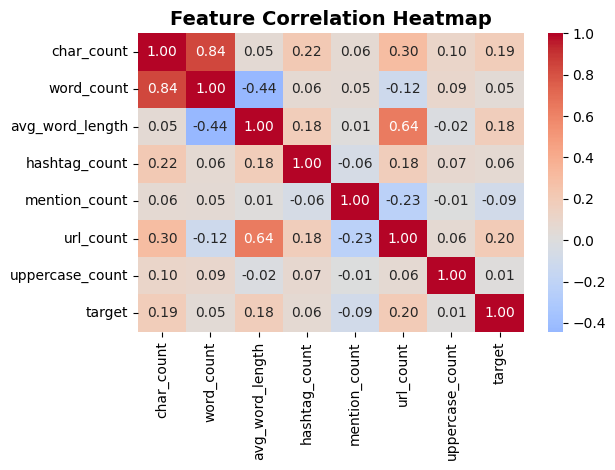


Features correlation with target (sorted):
target             1.000000
url_count          0.199150
char_count         0.187253
avg_word_length    0.179646
hashtag_count      0.062658
word_count         0.046487
uppercase_count    0.009534
mention_count     -0.092375
Name: target, dtype: float64


In [10]:
# to preserve integrity we recreate dataframes from already split data set
train_df_split = pd.DataFrame({'text': train_texts, 'target': train_labels})
val_df_split = pd.DataFrame({'text': val_texts, 'target': val_labels})
test_df_split = pd.DataFrame({'text': test_texts, 'target': test_labels})

# create some new numerical features
def create_text_features(df):
    df['char_count'] = df['text'].apply(len)
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    df['avg_word_length'] = df['text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
    df['hashtag_count'] = df['text'].apply(lambda x: len([word for word in str(x).split() if word.startswith('#')]))
    df['mention_count'] = df['text'].apply(lambda x: len([word for word in str(x).split() if word.startswith('@')]))
    df['url_count'] = df['text'].apply(lambda x: len([word for word in str(x).split() if 'http' in word.lower()]))
    df['uppercase_count'] = df['text'].apply(lambda x: len([word for word in str(x).split() if word.isupper() and len(word) > 1]))
    return df

# apply features
train_df_split = create_text_features(train_df_split)
val_df_split = create_text_features(val_df_split)
test_df_split = create_text_features(test_df_split)

# display statistics statistics
feature_cols = ['char_count', 'word_count', 'avg_word_length', 
                'hashtag_count', 'mention_count', 'url_count', 'uppercase_count']
print("feature statistics by target:")
print(train_df_split.groupby('target')[feature_cols].mean())

# because these are numerical features, we can also get correlation with target
correlation_features = feature_cols + ['target']
correlation_matrix = train_df_split[correlation_features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
print("\nFeatures correlation with target (sorted):")
print(correlation_matrix['target'].sort_values(ascending=False))

In [11]:
# MODEL 3: Bag of Words with Hyperparam Optimization and Feature Engineering
# we repeat the same grid search as earlier but now with a new data set
# vectorizing tweets from the split data

max_tokens = 5000
text_vectorization = keras.layers.TextVectorization(
    max_tokens = max_tokens,
    output_mode = "multi_hot"
)
text_vectorization.adapt(train_texts)
X_train = text_vectorization(train_texts)
X_val = text_vectorization(val_texts)
X_test = text_vectorization(test_texts)

# defining targets 
y_train = train_labels
y_val = val_labels
y_test = test_labels

# hyperparameter tuning function
def build_model(hp):
    input = keras.layers.Input(shape = X_train.shape[1:])
    x = input
    
    for i in range(hp.Int("num_layers", 1, 2)):  # varying number of layers
        x = keras.layers.Dense(
            units=hp.Choice(f"units_{i}", [8, 16, 32]),  # varying number of units
            activation="relu")(x)
        x = keras.layers.Dropout(hp.Choice("dropout", [0.0, 0.2, 0.5]))(x)  # varying dropout to prevent overfitting
    
    output = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(input, output)
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-3, 1e-4])),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

# tuner setup
tuner = kt.GridSearch(
    build_model,
    objective="val_accuracy", 
    overwrite=True 
) 

tuner.search_space_summary()
tuner.search(X_train,
             y_train,
             epochs = NUM_EPOCHS,
             batch_size = 32,
             verbose = 1,
             validation_data=(X_val, y_val))

Trial 72 Complete [00h 00m 03s]
val_accuracy: 0.7405405640602112

Best val_accuracy So Far: 0.8301158547401428
Total elapsed time: 00h 02m 35s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
test_pred = (best_model.predict(X_test) > 0.5).astype(int).flatten()
bowt_fe = evaluate_model(y_test, test_pred, model_name = "BoW (FE/Tuned)")
master_list.append(bowt_fe)
print_results(master_list)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Metric      Baseline       BoW (Simple)   BoW (Tuned)    BoW (FE + Tuned)
f1          0.0000         0.7571         0.7671         0.7623         
accuracy    0.5701         0.7977         0.8117         0.8100         
precision   0.0000         0.7826         0.8194         0.8246         
recall      0.0000         0.7332         0.7210         0.7088         


/Users/trishasutivong/.julia/conda/3/aarch64/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Step 3.2: Leveraging Transformers Encoding

In [13]:
from keras import ops
from keras import layers
from keras import ops

In [14]:
# importing keras subclassing API similar to recitation
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim,
                                             output_shape=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(dense_dim, activation = "relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [15]:
# transformer params 
max_tokens = 5000 # maximum vocab
max_length = 100  # maximum sequence length
embed_dim = 64   # number of elements of the embedding vectors 
num_heads = 4    # number of heads inside the multi-head attention
dense_dim = 128  # how many relus in the hidden layer

In [16]:
# MODEL 4: Transformer Encoding (No Feature Engineering)
text_vectorization = keras.layers.TextVectorization(
    max_tokens = max_tokens,
    output_mode = "int",
    output_sequence_length = max_length
)

text_vectorization.adapt(train_texts)

X_train = text_vectorization(train_texts)
X_val = text_vectorization(val_texts)
X_test = text_vectorization(test_texts)
y_train = train_labels
y_val = val_labels
y_test = test_labels

inputs = keras.layers.Input(shape=(max_length,))
# convert word indices to embeddings + add position info
embedding = TokenAndPositionEmbedding(max_length, max_tokens, embed_dim)
x = embedding(inputs) # the grey encoder before being contextualized 
# contextualizing the embedding, this is the blue vector 
encoder_out = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

# aggregating the sequence of words into a single vector 
x = keras.layers.GlobalAveragePooling1D()(encoder_out) # average treats all positions the same

# standard classifier 
x = keras.layers.Dense(128, activation = "relu")(x)
x = keras.layers.Dropout(0.1)(x)
outputs = keras.layers.Dense(1, activation = "sigmoid")(x) 
model = keras.Model(inputs, outputs)
model.summary()

model.compile(optimizer = "adam", 
              loss = "binary_crossentropy", 
              metrics =[ "accuracy"])

history = model.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = NUM_EPOCHS,
    batch_size = 32
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 100, 64)        │       326,400 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 100, 64)        │        83,200 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 418,049 (1.59 MB)

 Trainable params: 418,049 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.5568 - loss: 0.6900 - val_accuracy: 0.5714 - val_loss: 0.6683
Epoch 2/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7823 - loss: 0.4870 - val_accuracy: 0.8131 - val_loss: 0.4392
Epoch 3/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8607 - loss: 0.3339 - val_accuracy: 0.7931 - val_loss: 0.4958
Epoch 4/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9049 - loss: 0.2493 - val_accuracy: 0.7884 - val_loss: 0.6088
Epoch 5/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9339 - loss: 0.1827 - val_accuracy: 0.7822 - val_loss: 0.7468


In [17]:
# evaluate results
test_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
transformer_base = evaluate_model(y_test, test_pred, model_name="Transformer")
master_list.append(transformer_base)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [18]:
# MODEL 5: Transformer Encoding (With Feature Engineering)
text_vectorization = keras.layers.TextVectorization(
    max_tokens = max_tokens,
    output_mode = "int",
    output_sequence_length = max_length
)

text_vectorization.adapt(train_texts)

X_train = text_vectorization(train_texts)
X_val = text_vectorization(val_texts)
X_test = text_vectorization(test_texts)
y_train = train_labels
y_val = val_labels
y_test = test_labels

# extract engineered features from dataframes
X_train_features = train_df_split[feature_cols].values
X_val_features = val_df_split[feature_cols].values
X_test_features = test_df_split[feature_cols].values

# text input
text_input = keras.layers.Input(shape=(max_length,), name="text")
# feature input 
feature_input = keras.layers.Input(shape=(len(feature_cols),), name="features")

# convert word indices to embeddings + add position info
embedding = TokenAndPositionEmbedding(max_length, max_tokens, embed_dim)
x = embedding(text_input) # the grey encoder before being contextualized 
# contextualizing the embedding, this is the blue vector 
encoder_out = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

# aggregating the sequence of words into a single vector 
x = keras.layers.GlobalAveragePooling1D()(encoder_out) # average treats all positions the same

# combine transformer output with engineered features
combined = keras.layers.Concatenate()([x, feature_input])

# standard classifier 
x = keras.layers.Dense(128, activation = "relu")(combined)
x = keras.layers.Dropout(0.1)(x)
outputs = keras.layers.Dense(1, activation = "sigmoid")(x) 
model = keras.Model(inputs=[text_input, feature_input], outputs=outputs)
model.summary()

model.compile(optimizer = "adam", 
              loss = "binary_crossentropy", 
              metrics = ["accuracy"])

history = model.fit(
    [X_train, X_train_features], y_train,
    validation_data = ([X_val, X_val_features], y_val),
    epochs = 8, # adjusted since transformer seems to take longer to learn
    batch_size = 32
)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 100)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 100, 64)   │    326,400 │ text[0][0]        │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 100, 64)   │     83,200 │ token_and_positi… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ transformer_enco… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features            │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 71)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │      9,216 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │        129 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 418,945 (1.60 MB)

 Trainable params: 418,945 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
162/162 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.5301 - loss: 1.3619 - val_accuracy: 0.5683 - val_loss: 0.7823
Epoch 2/8
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5701 - loss: 0.9590 - val_accuracy: 0.5699 - val_loss: 0.6864
Epoch 3/8
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6387 - loss: 0.7379 - val_accuracy: 0.7313 - val_loss: 0.7067
Epoch 4/8
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7886 - loss: 0.4895 - val_accuracy: 0.7815 - val_loss: 0.5414
Epoch 5/8
162/162 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8735 - loss: 0.3165 - val_accuracy: 0.7822 - val_loss: 0.6581
Epoch 6/8
162/162 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9150 - loss: 0.2314 - val_accuracy: 0.7792 - val_loss: 0.7387
Epoch 7/8
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9339 - loss: 0.1801 - val_accuracy: 0.7653 - val_loss: 0.8696
Epoch 8/8
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9490 - loss: 0.1433 - val_accuracy: 0.

In [19]:
# evaluate on test set
test_pred = (model.predict([X_test, X_test_features]) > 0.5).astype(int).flatten()
transformer_fe = evaluate_model(y_test, test_pred, model_name = "Transformer (FE)")
master_list.append(transformer_fe)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [20]:
print_results(master_list)


Metric      Baseline       BoW (Simple)   BoW (Tuned)    BoW (FE + Tuned)Transformer    Transformer (FE)
f1          0.0000         0.7571         0.7671         0.7623         0.7036         0.6922         
accuracy    0.5701         0.7977         0.8117         0.8100         0.7566         0.7250         
precision   0.0000         0.7826         0.8194         0.8246         0.7383         0.6673         
recall      0.0000         0.7332         0.7210         0.7088         0.6721         0.7189         


### Step 3.2: Leveraging Pre-Trained Models (BERT)

In [21]:
import keras_hub
import tensorflow_text as tf_text

In [24]:
# using RoBERTa
classifier = keras_hub.models.RobertaClassifier.from_preset(
    "roberta_base_en",
    num_classes = 2,  # we are doing binary classification
)
classifier.backbone.trainable = False

In [25]:
# re-compile roberta with a new slow learning rate
classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate = 2e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# fit the model, RoBERTa handles tokenization internally
history = classifier.fit(
    x = train_texts, 
    y = train_labels, 
    batch_size = 16,
    epochs = 3,  # small epochs to not overfit 
    validation_data = (val_texts, val_labels)
)

# evaluate on test set
test_pred = classifier.predict(test_texts).argmax(axis = 1) 
roberta = evaluate_model(y_test, test_pred, model_name = "RoBERTa")
master_list.append(roberta)
print_results(master_list)

Epoch 1/3
  4/324 ━━━━━━━━━━━━━━━━━━━━ 46:43 9s/step - accuracy: 0.5547 - loss: 1.3735

KeyboardInterrupt: 

### Step 4: Ensemble Models

In [ ]:
# take our best 2 models and create an ensemble 

### Step 5: Evaluation

In [ ]:
# plotting of all models 
